# 10 Neuron Parameter Study
> Vary the conductivity matrices for a neural network, fixing the number of neurons as well as the individual neuron "identities": i.e. the conductances and reversal potentials are varied slightly for each neuron, but for each run, the same neurons are used.

## To Do:
1. Define 10 individual, reusuable neurons --> Matrices within odes_progen
2. Read in the conductivity matrices
3. Verify that the 10 individual neurons are functional (do we care?)
4. Run trials
5. Save data
6. Print output

In [29]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import network_funcs
import os.path

COLOR = 'grey'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [30]:
def read_SC(node, numNodes):
    my_path = os.getcwd() + r"\\NetworkCouplingParams\\" + "x10_0_5.npy"
    
    my_array = np.load(my_path)
    
    my_string = str(my_array[node-1,:])
    my_string = my_string.replace('\n','')
    for char in my_string:
        if char in "[],\n/;:":
            my_string = my_string.replace(char,'')
    
    my_keys = [val+1 for val in range(numNodes)]
    my_vals = my_string.split()
    my_dict = {}
    count = 0
    for key in my_keys:
        my_dict[key] = my_vals[count]
        count += 1
    
    return my_dict

In [31]:
def odes_progen(x,t,I,vI):
    '''
    Defines the constants and differential equations for the base Hodgkin-Huxley equations

    Params:: 
        x: all network parameters
        t: time vector, not called in func but regardless (but used in odeint)
        I: custom function, time varying current (square wave)
        vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function

    Returns:: Differential equations of each variable as a vector
    '''
    
    ######### DEFINITIONS #########
    
    ### THIS IS MANUALLY SET AND MUST MATCH THE INPUT ###
    maxParams = 5 #Takes advantage of the fact that there will be a tau, v0, inf, etc. for each gating var
    #^ ie we can keep reusing this since there will be the same number of parameters necessary for each gating var
    #This is quasi-manual, based on the maxParams being 5... could probably make the equation itself automated?
    numNodes = 10

    numSC = numNodes #calc_conx(numNodes)*2 <-- This is the total number of connections, but we only need to pass the max number of connections per node in for each node
    #Changed to reflect the fact that we are now passing in the max always
    ES = [0] * numSC #ENa #mV #Excitatory Neuron (by this definition)
    
    #Convert list input into a matrix
    numParams = 1+4*maxParams+numSC #In this current form, there are 26 parameters per node.  I.e. 1 node is (1,26)
    x = np.reshape(x,(numNodes,numParams))
    
    if len(x.shape)==1:
        #Ie if it is 1D, expand the dim to be (1,X) so that we can index as if it were 2D
        x = np.expand_dims(x,0)
        
    firstSIndex = numParams-numSC
    
    infs = np.zeros((numNodes,maxParams))
    taus = np.zeros((numNodes,maxParams))
    dxdts = np.zeros((numNodes,numParams)) #ONE FOR EACH VAR PASSED IN THROUGH Y0

    ######### CONSTANTS #########
    CmBase = 0.01 #uF
    #Altering the current for the nodes, essentially weighting them
    #In the test trials in NB 10, we used 1x for node1, and 0x for node2
    node_current = [0]*numNodes
    node_current[0] = 1
    #if numNodes>1:
    #    #Do something more advanced later
    #    node_current[1] = 0
    node_current = np.array(node_current)*(1/CmBase)
    
    #For the synaptic coupling: 
    #^20 was a "good value" (ie one for which it functioned) in the previous NB
    gbars = [20] * numSC
    
    #Defining 10 individual neurons
    WM = np.array([[0.95, 0.89, 1.1, 1.03, 1.04, 0.99, 0.93],[1.17, 0.97, 0.92, 1.1, 1.23, 0.91, 0.95],[0.88, 0.97, 0.95, 0.93, 0.99, 0.89, 0.92],[1.02, 1.03, 1.04, 0.99, 1.02, 0.91, 1.05],[1.06, 0.97, 1.07, 1.04, 0.94, 1.03, 0.93],[1.02, 1.03, 0.99, 1.01, 1.04, 0.99, 0.98],[0.92, 0.98, 1.06, 0.92, 0.92, 1.02, 1.01],[0.9, 1.1, 1.1, 0.93, 0.93, 1.1, 0.93],[1.03, 1.09, 1.02, 1.01, 1.02, 1.09, 1.03],[1.05, 0.99, 0.98, 0.97, 0.99, 1.02, 0.99]])
    
    ######### LOOPING #########
    
    for nodeTemp in range(numNodes):  
        #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
        #reversal potentials
        ENa = 55.17*WM[nodeTemp,0] #mV
        EK = -72.14*WM[nodeTemp,1] #mV
        EL = -57.99*WM[nodeTemp,2] #-49.42 #mV
        #E4
        #E5
        #membrane capacitance
        Cm = CmBase*WM[nodeTemp,3] #uF/cm^2
        
        #conductances (S is Siemens)
        gbarK = 0.36*WM[nodeTemp,4] #mS/cm2
        gbarNa = 1.2*WM[nodeTemp,5] #mS/cm2
        gbarL = 0.003*WM[nodeTemp,6] #mS/cm2
        #So really there should be other values here for the 4th and 5th gating variables should those get used
        #gbar?(4) = ___
        #gbar?(5) = ___

        #For now, defining every neuron the same, but can change the "n,m,h" values...
        gK = (1/Cm)*gbarK*(x[nodeTemp,1]**4) #Why did I have a +maxParams after the 1?
        gNa = (1/Cm)*gbarNa*(x[nodeTemp,2]**3)*x[nodeTemp,3]
        gL = (1/Cm)*gbarL
        #Again, would need to add something for the 4th and 5th gating variables should they exist
        #...
        
        #Simplification: check connection in external function
        vnode_couplings = []
        svars = []   
        if numNodes==1:
            svars = [0]*numSC #1 neuron, so no connections.  Just return 0s
        else:
            #SC_repo = network_funcs.check_SC(nodeTemp,numNodes) #RETURNS A DICTIONARY
            SC_repo = read_SC(nodeTemp,numNodes) #RETURNS A DICTIONARY

            if SC_repo is not None and len(SC_repo)>0:
                for idx in range(numNodes):
                    idx += 1 #Adjust for offset, first node is 1 not 0
                    if SC_repo.get(idx) is not None:
                        adj_idx = int(idx)-1
                        vnode_couplings.append(adj_idx) #This is the node that it is coupled to
                        sval = float(SC_repo.get(idx))
                        svars.append(sval) #This is the s val, to be used in gs

                #Don't think this loop should actually ever run anymore
                while len(svars)<numSC:
                    vnode_couplings.append(0)
                    svars.append(0)

                my_zeros = [0]*(firstSIndex) #Ie a 1,21 vector of zeros, so once we add the 5 couplings to it, it meets 26
                svars_full = my_zeros+svars
                vnode_couplings_full = my_zeros+vnode_couplings
            else:
                print("Error: SC_repo returned None")
        gs = np.array(gbars) * np.array(svars) #* (1/Cm)

        #Define the steady state (inf) values, and the time constants (tau)
        #Note that this must be completed first, so that all the taus, infs are defined before we can make the ODEs
        for param in range(maxParams):
            #inf(V, v0, sigma)
            infs[nodeTemp,param] = network_funcs.inf_func(x[nodeTemp,0], x[nodeTemp,param+(1+maxParams)], x[nodeTemp,param+(1+2*maxParams)])
            #tau(V, mean)
            taus[nodeTemp,param] = network_funcs.tau_func(x[nodeTemp,0], x[nodeTemp,param+(1+3*maxParams)])

        #Define each ODE    
        for param in range(numParams): 
            if param==0:
                #dVdt = (gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + gs1*(ES1-Va) + ... + gsn*(ESn-Vz) + I(t,vI))
                
                #TERM 1
                ionChannels = gNa*(ENa-x[nodeTemp,0]) + gK*(EK-x[nodeTemp,0]) + gL*(EL-x[nodeTemp,0])
                #Would need to include the 4th and 5th gating variables somehow...
                #How to make this automatic instead of manual...
                
                #TERM 2
                synCoups = 0
                for idx in range(numSC):
                    #Replaced vnode_couplings[idx]-1 with idx
                    synCoups += gs[idx]*(ES[idx]-x[nodeTemp,0])
                    #^ Terms: (conducance gs_x) * (ES - V)

                #TERM 3
                appliedCurrent = I(t,vI)*node_current[nodeTemp]

                dxdts[nodeTemp,param] = ionChannels + synCoups + appliedCurrent
            elif param<(maxParams+1): #ie the gating variables
                #Note we use [nodeTemp,param-1] because there is no tau/inf for V so the matrix tau starts with n @ index 0
                dxdts[nodeTemp,param] = network_funcs.diffEQ_func(taus[nodeTemp,param-1], infs[nodeTemp,param-1], x[nodeTemp,param]) 
            elif param>=firstSIndex and sum(svars_full)==0: #ie if all the s vars are equal to zero
                break #ie just leave them as zero, and we are done with the loop so we can just break
            elif param>=firstSIndex:
                #STILL MANUAL
                tau_s = 30 #ms
                s_inf = 10.0/11.0 
                beta_s = 1/tau_s
                
                if numNodes==1:
                    pass #ie dsdts remain zeros
                else:
                    s = svars_full[param]
                    if s==0:
                        #Not sure if this will ever happen
                        #Goal is to get around cases where no s is passed in so s is 0
                        #^Maybe initilize that array to something biophysically impossible (e.g. can s be neagtive?)
                        dxdts[nodeTemp,param] = 0 
                    else:
                        coupled_neuron = vnode_couplings_full[param]
                        #coupled_neuron-1 because Neuron 1 corresponds to row 0
                        alpha_s = (x[coupled_neuron-1,0]>0)*(1/tau_s)

                        dxdts[nodeTemp,param] = alpha_s*(1-s)-beta_s*s 
                
                #This should be the last case, it will run once the way it currently configured
                #break
            else:
                pass
                #Should just be equal to zero, so leave as is (matrix is initialized as zeros)
    
    #Rearrange dxdts into a list so that we can unpack it
    flat_array = dxdts.flatten()
    ODE_list = flat_array.tolist()
    
    return ODE_list

In [34]:
#Things that don't need to be assigned every time
t = np.linspace(0,100,3000) #time vector
vI = [0,0,0] #vector needed to control the current
V1 = -58; n1 = 0.05; m1 = 0.33; h1 = 0.6 #Voltage and gating var ICs
#V0: Manipulates the x location placement
V0n1 = -49; V0m1 = -36; V0h1 = -55
#Sigma: Manipulates the steepness, bigger sigma means less steep step
sigman1 = 18; sigmam1 = 10; sigmah1 = -8
#Tau's
tau_n_mean1 = 2.785; tau_m_mean1 = 0.258; tau_h_mean1 = 2.810
node1Base = [V1, n1, m1, h1, 0, 0, 
         V0n1, V0m1, V0h1, 0, 0, 
         sigman1, sigmam1, sigmah1, 0, 0, 
         tau_n_mean1, tau_m_mean1, tau_h_mean1, 0, 0]

In [35]:
def runSim(vI,numNodes=1,plot_BI=True,plot_final=True,useCurrent=True,isVerbose=0,my_tol=1.49012e-8):
    print("Burn in run, looking for NO oscillations")
    node1 = node1Base + ([0]*(numNodes))
    network_params = node1*numNodes #Letting all nodes be the same
    if isVerbose:
        x, my_verbosity = odeint(odes_progen,network_params,t,full_output=isVerbose,rtol=my_tol,args=(network_funcs.I,[0,0,0]))
        print(my_verbosity)
    else:
        x = odeint(odes_progen,network_params,t,full_output=isVerbose,rtol=my_tol,args=(network_funcs.I,[0,0,0]))
    x = np.transpose(x)
    if plot_BI:
        network_funcs.plot_vnmh(x,t,numNodes)
    #Now grab the burned in values from the previous run
    network_params_BI = x[:,-1]
    print("Burn in complete")
    
    print("Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected")
    #BURNED IN initial condition
    #if useCurrent:
    #    vI = [5,7,0.1]
    if isVerbose:
        x, my_verbosity = odeint(odes_progen,network_params_BI,t,rtol=my_tol,full_output=isVerbose,args=(network_funcs.I,vI))
        print(my_verbosity)
    else:
        x = odeint(odes_progen,network_params_BI,t,full_output=isVerbose,rtol=my_tol,args=(network_funcs.I,vI))
    x = np.transpose(x)
    if plot_final:
        network_funcs.plot_vnmh(x,t,numNodes)
    return x

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


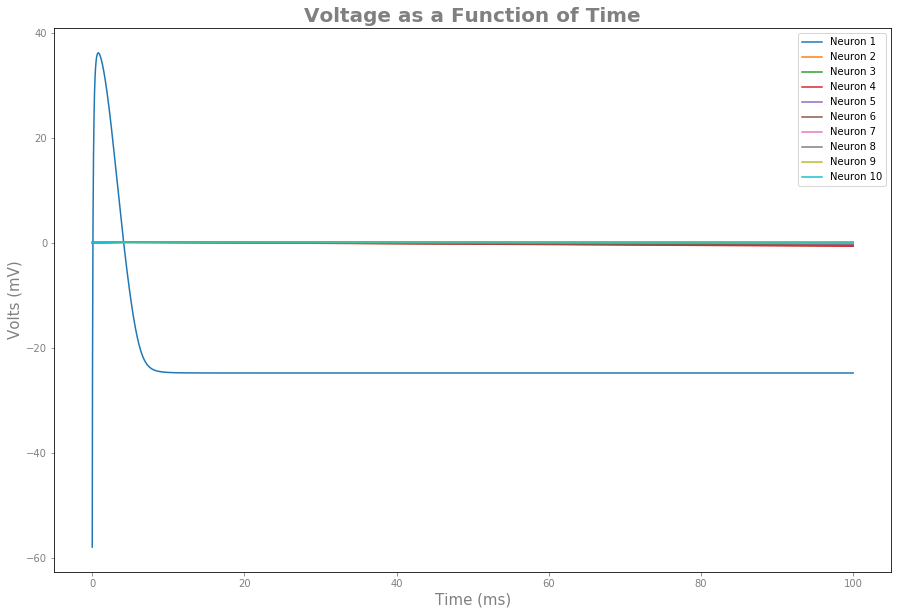

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


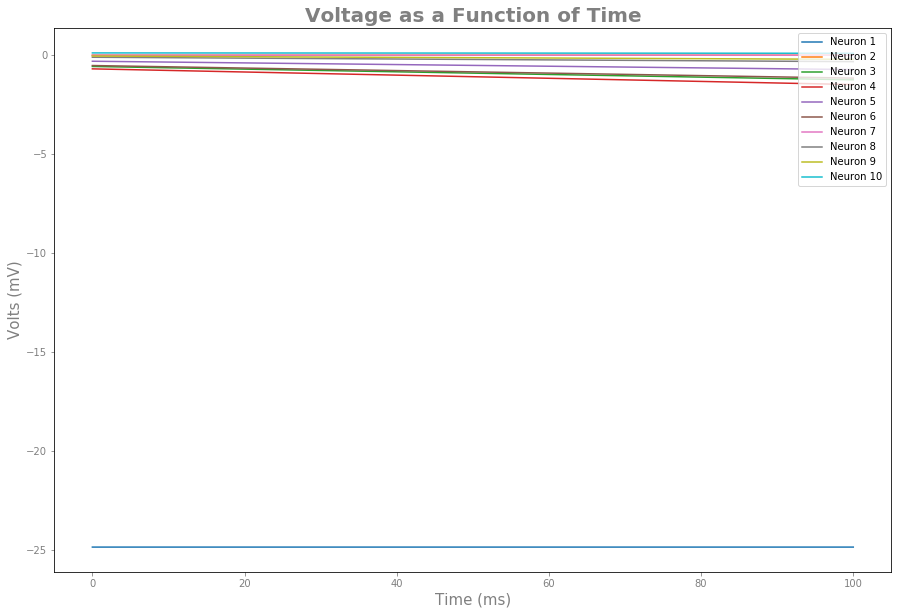

In [36]:
#numNodes, numZeros, trialNum (trialNum should actually be 1)
#"x10_0_5.npy"
vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=10,plot_BI=True)

In [ ]:
#numNodes, numZeros, trialNum (trialNum should actually be 1)
#"x10_90_5.npy"
vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=10,plot_BI=False)

Burn in run, looking for NO oscillations
Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


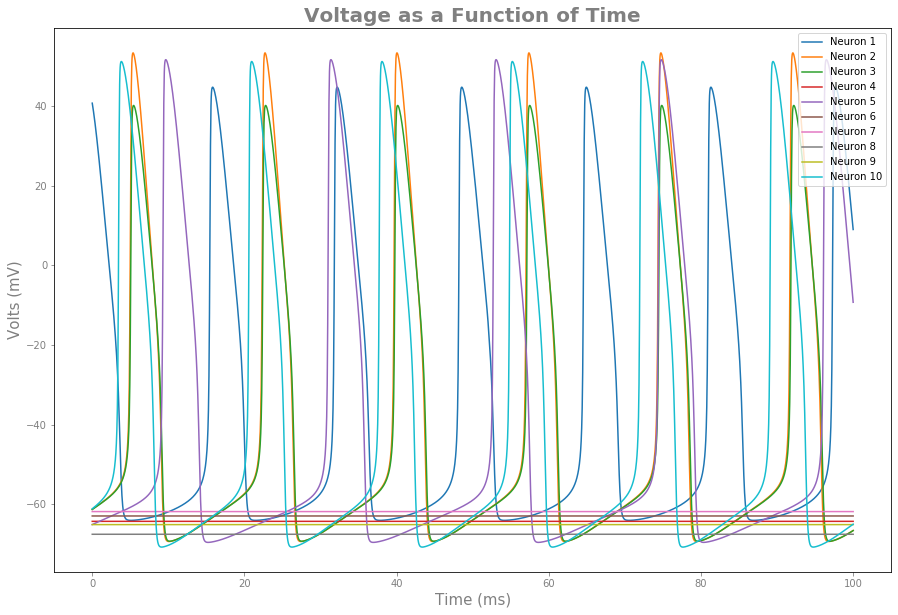

In [26]:
#numNodes, numZeros, trialNum (trialNum should actually be 1)
#"x10_90_5.npy"
vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=10,plot_BI=False)

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


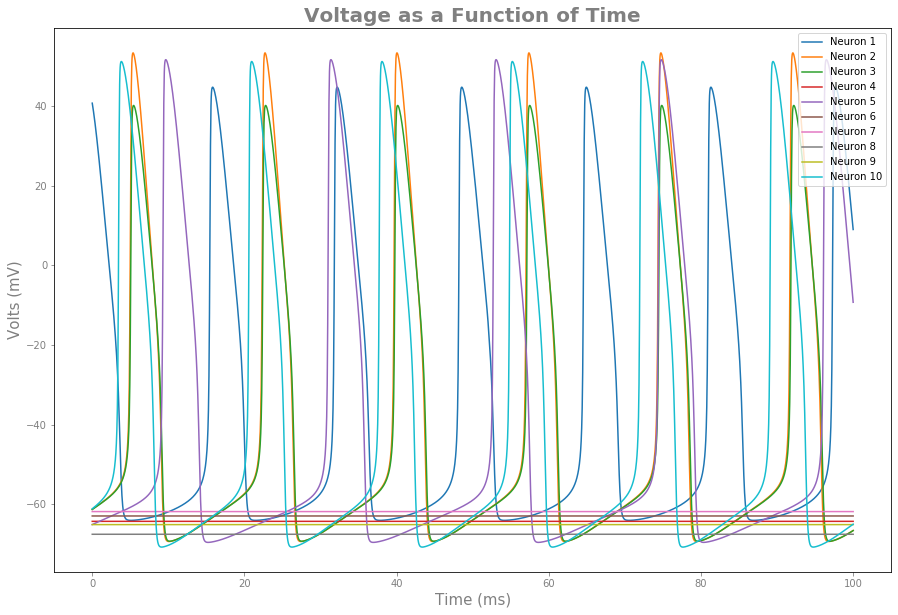

In [31]:
#numNodes, numZeros, trialNum (trialNum should actually be 1)
#"x10_0_5.npy"
vI = [50,52,0.1]
updatedCurrent_0 = runSim(vI,numNodes=10,plot_BI=False)
np.save("10NN_0",updatedCurrent_0)

In [ ]:
#"x10_9_5.npy"
vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=10,plot_BI=False)

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


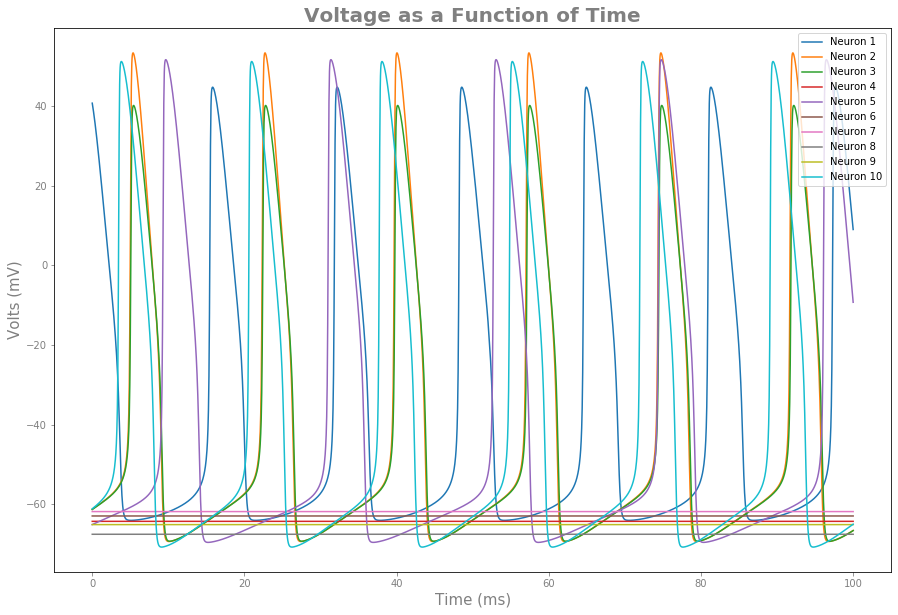

In [11]:
#"x10_90_5.npy"
vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=10,plot_BI=False)

In [13]:
#Saving the below case
Results_10_90 = updatedCurrent1
filename = "Results_10_90"
save_path = os.getcwd() + r"\\NetworkCouplingParams"
completeName = os.path.join(save_path, filename)
np.save(completeName,Results_10_90)

## Runs to complete in the future

In [ ]:
#"x10_0_5.npy"
vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=10,plot_BI=False)

In [ ]:
#"x10_0_5.npy"
vI = [50,52,0.1]
updatedCurrent1 = runSim(vI,numNodes=10,plot_BI=False)

## Burn in, no current run
> Just testing to see if 10 NN is functional.  It appears to be so

In [12]:
#Saving the below case
base10_NoCurrent = noCurrent1
filename = "base10_NoCurrent"
save_path = os.getcwd() + r"\\NetworkCouplingParams"
completeName = os.path.join(save_path, filename)
np.save(completeName,base10_NoCurrent)

NameError: name 'noCurrent1' is not defined

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


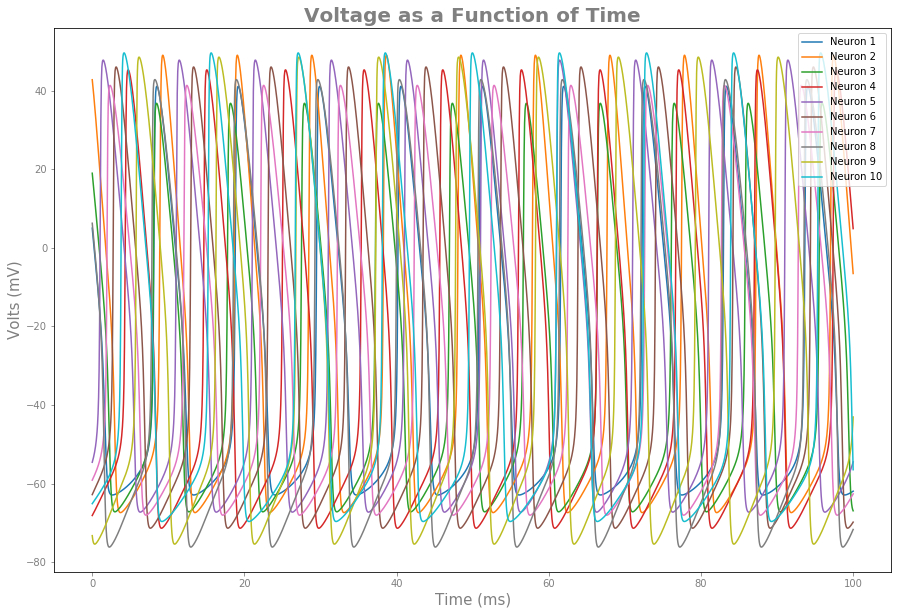

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


KeyboardInterrupt: 

In [16]:
vI = [0,0,0]
noCurrent1 = runSim(vI,numNodes=10,plot_BI=False)